In [37]:
%matplotlib inline
%matplotlib widget
import backtrader.plot
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
import tushare as ts
from datetime import datetime
import backtrader as bt
import pandas as pd
import os


In [2]:
# Create a subclass of Strategy to define the indicators and logic
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )
    def __init__(self):
        super().__init__()
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=1)  # enter long
                # self.buy()
        elif self.crossover < 0:  # in the market & cross to the downside
            self.order_target_size(target=0)  # close long position
            # self.close()

In [50]:
data_path = './data/'
if not os.path.exists(data_path):
    os.makedirs(data_path)
mytoken='565ee6d69fb85cb0bc7fdfc8dea4b8ce1f18366f30e8d23a253bb9cf'
class Strategy_runner:
    def __init__(self, strategy, ts_code, start_date, end_date, data_path=data_path, pro=False, token=mytoken):
        self.ts_code = ts_code
        self.start_date = start_date
        self.end_date = end_date
        # convert to datetime
        self.start_datetime = datetime.strptime(start_date,'%Y%m%d')
        self.end_datetime = datetime.strptime(end_date,'%Y%m%d')
        if pro:
            csv_name = f'pro_day_{str(ts_code)}-{str(start_date)}-{str(end_date)}.csv'
        else:
            csv_name = f'day_{str(ts_code)}-{str(start_date)}-{str(end_date)}.csv'
        csv_path = os.path.join(data_path,csv_name)
        if os.path.exists(csv_path):
            if pro:
                self.df = pd.read_csv(csv_path)
            else:
                self.df = pd.read_csv(csv_path,index_col=0)
        else:
            if pro:
                ts.set_token(mytoken)
                self.pro = ts.pro_api()
                self.df = self.pro.daily(ts_code=self.ts_code, start_date=self.start_date, end_date=self.end_date)
                if not self.df.empty:
                    self.df.to_csv(csv_path, index=False)
            else:
                self.df = ts.get_hist_data(self.ts_code, str(self.start_datetime), str(self.end_datetime))
                if not self.df.empty:
                    self.df.to_csv(csv_path, index=True)
            
        self.df_bt = self.preprocess(self.df, pro)
        print(self.df_bt)
        self.strategy = strategy
        self.cerebro = bt.Cerebro()
        

    def preprocess(self, df, pro=False):
        if pro:
            features=['open','high','low','close','vol','trade_date']
            # convert_datetime = lambda x:datetime.strptime(x,'%Y%m%d')
            convert_datetime = lambda x: pd.to_datetime(str(x))
            df['trade_date'] = df['trade_date'].apply(convert_datetime)
            print(df)
            bt_col_dict = {'vol':'volume','trade_date':'datetime'}
            df = df.rename(columns=bt_col_dict)
            df = df.set_index('datetime')
            # df.index = pd.DatetimeIndex(df.index)
        else:
            features=['open','high','low','close','volume']
            df = df[features]
            df['openinterest'] = 0
            df.index = pd.DatetimeIndex(df.index)

        df = df[::-1]
        return df

    def run(self):
        data = bt.feeds.PandasData(dataname=self.df_bt,                               
                                    fromdate=self.start_datetime,                               
                                    todate=self.end_datetime)
        self.cerebro.adddata(data)  # Add the data feed
        self.cerebro.addstrategy(self.strategy)  # Add the trading strategy
        self.cerebro.broker.setcash(100000.0)
        # self.cerebro.addsizer(bt.sizers.FixedSize, stake=10)
        # self.cerebro.broker.setcommission(commission=0.0)
        self.cerebro.addanalyzer(bt.analyzers.SharpeRatio,_name = 'SharpeRatio')
        self.cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
        self.results = self.cerebro.run()
        strat = self.results[0]
        print('Final Portfolio Value: %.2f' % self.cerebro.broker.getvalue())
        print('SR:', strat.analyzers.SharpeRatio.get_analysis())
        print('DW:', strat.analyzers.DW.get_analysis())
        return self.results
    
    def plot(self, iplot=False):
        self.cerebro.plot(iplot=iplot)

ts_code trade_date  open  high   low  close  pre_close  change  \
0    600515.SH 2019-12-31  4.55  4.56  4.41   4.46       4.56   -0.10   
1    600515.SH 2019-12-30  4.82  4.82  4.50   4.56       4.38    0.18   
2    600515.SH 2019-12-27  4.45  4.49  4.38   4.38       4.50   -0.12   
3    600515.SH 2019-12-26  4.48  4.68  4.46   4.50       4.54   -0.04   
4    600515.SH 2019-12-25  4.53  4.57  4.46   4.54       4.61   -0.07   
..         ...        ...   ...   ...   ...    ...        ...     ...   
239  600515.SH 2019-01-08  4.91  4.94  4.88   4.92       4.92    0.00   
240  600515.SH 2019-01-07  4.91  4.95  4.87   4.92       4.86    0.06   
241  600515.SH 2019-01-04  4.68  4.86  4.64   4.86       4.75    0.11   
242  600515.SH 2019-01-03  4.76  4.79  4.65   4.75       4.75    0.00   
243  600515.SH 2019-01-02  4.76  4.84  4.71   4.75       4.71    0.04   

     pct_chg        vol      amount  
0    -2.1930  341845.37  152701.382  
1     4.1096  583561.14  272533.315  
2    -2.6667  24

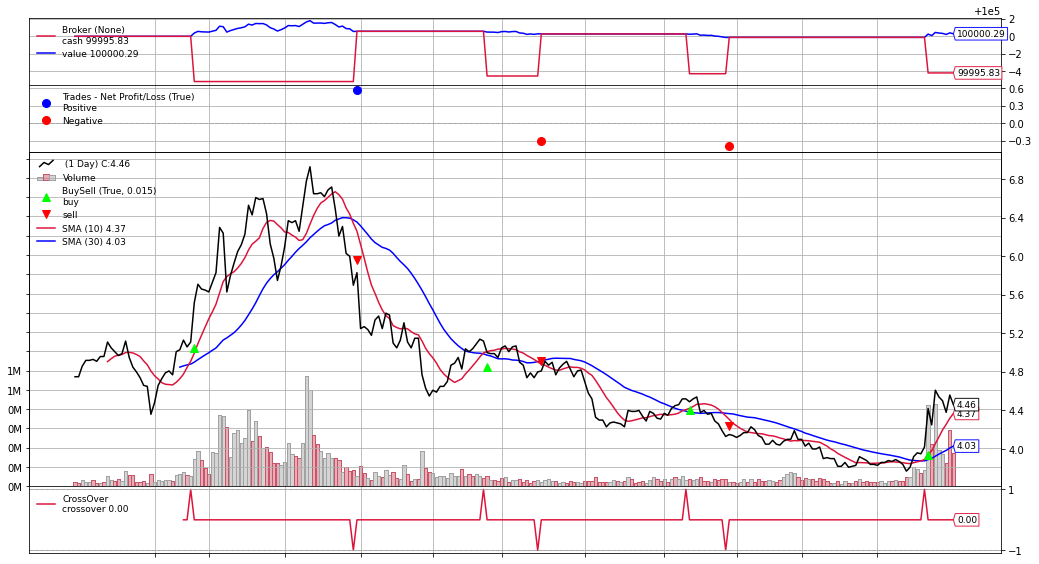

In [51]:
ts_code='600515.SH'
start_date='20190101'
end_date='20191231'
strategy_runner = Strategy_runner(strategy=SmaCross, ts_code=ts_code, start_date=start_date, end_date=end_date, pro=True)
results = strategy_runner.run()
strategy_runner.plot()

In [52]:
ts_code='600515'
start_date='20190101'
end_date='20191231'
strategy_runner = Strategy_runner(strategy=SmaCross, ts_code=ts_code, start_date=start_date, end_date=end_date, pro=False)
results = strategy_runner.run()

open  high   low  close     volume  openinterest
date                                                        
2019-01-02  4.76  4.84  4.71   4.75   48626.88             0
2019-01-03  4.76  4.79  4.65   4.75   36591.72             0
2019-01-04  4.68  4.86  4.64   4.86   64998.66             0
2019-01-07  4.91  4.95  4.87   4.92   49722.38             0
2019-01-08  4.91  4.94  4.88   4.92   42582.90             0
...          ...   ...   ...    ...        ...           ...
2019-12-25  4.53  4.57  4.46   4.54  375564.00             0
2019-12-26  4.48  4.68  4.46   4.50  340056.50             0
2019-12-27  4.45  4.49  4.38   4.38  246122.59             0
2019-12-30  4.82  4.82  4.50   4.56  583561.12             0
2019-12-31  4.55  4.56  4.41   4.46  341845.38             0

[244 rows x 6 columns]
Final Portfolio Value: 100000.29
SR: OrderedDict([('sharperatio', None)])
DW: AutoOrderedDict([('len', 178), ('drawdown', 0.0014899734784627702), ('moneydown', 1.4899999999906868), ('max', AutoOr

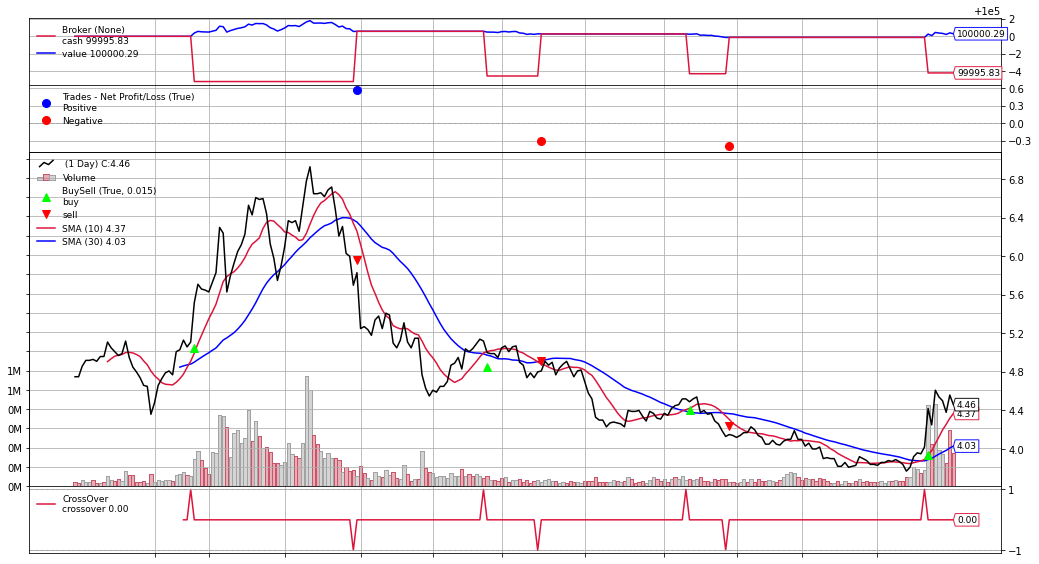

In [53]:
strategy_runner.plot()